# Before you start

Before you review this notebook, please spend an hour or two on your own familiarizing yourself with the data, thinking about the problem, and the approach you would like to take.  If you just jump into the starter code, you will miss out on your own creative thinking, and limit yourself to what you see here.   

***

**First, some library imports**

In [421]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay


# Complaints dataset from CFPB  
## Load the data  
First, we load the dataset.  We use the file in the `shared\` folder.

In [422]:
# To load the data directly from the CFPB website, use the below command.  Be aware you will get lots of data!
# You will then need to filter it for just the 5 banks we are interested in analyzing.
# complaints = pd.read_csv(r'https://files.consumerfinance.gov/ccdb/complaints.csv.zip')

In [423]:
# Load dataset from provided file.  Be sure to use the correct path.

complaints = pd.read_csv('complaints_25Nov21.csv')

# complaints = pd.read_csv('shared/complaints_25Nov21.csv')

## Review the data
The next few cells look at the data in a couple of different ways.  This does not cover graphing and visualization, but you should do that.

In [424]:
# How many rows and columns do we have?

complaints.shape

(207260, 18)

In [425]:
# What are the column names?

complaints.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [426]:
# Let us look at which banks have the most number of complaints

complaints['Company'].value_counts().sort_values(ascending=False)

BANK OF AMERICA, NATIONAL ASSOCIATION    65440
WELLS FARGO & COMPANY                    53111
JPMORGAN CHASE & CO.                     42170
CITIBANK, N.A.                           34341
U.S. BANCORP                             12198
Name: Company, dtype: int64

In [427]:
# Because the data is already pre-filtered to the top-5 companies, we do not need to run the below commands.
# But if you are using the file directly from the CFPB website, you will need to do this as we want to analyze
# only the top-5 banks.

# banks = ['BANK OF AMERICA, NATIONAL ASSOCIATION', 'WELLS FARGO & COMPANY','JPMORGAN CHASE & CO.', 'CITIBANK, N.A.' , 'U.S. BANCORP']
# filtered = complaints[(complaints['Company'].isin(banks))]
# filtered.to_csv("complaints_14Nov21.csv", index=False)

In [428]:
# Let us get a feel for the data

complaints.head(10)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647
5,2017-01-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2017-02-02,Closed with explanation,Yes,No,2317362
6,2014-02-21,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,JPMORGAN CHASE & CO.,CA,92592,NaN,NaN,Web,2014-02-20,Closed with explanation,Yes,No,725150
7,2016-10-14,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,MD,21222,NaN,NaN,Phone,2016-10-14,Closed with explanation,Yes,No,2161603
8,2014-01-15,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,WELLS FARGO & COMPANY,VA,228XX,Older American,NaN,Phone,2014-01-22,Closed with explanation,Yes,Yes,670395
9,2016-09-19,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,"Mortgage Fraud, defective title, defective mor...",Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",MN,NaN,NaN,Consent provided,Web,2016-10-05,Closed with explanation,Yes,Yes,2118743


## Predicting 'Consumer Disputed'

We look at the distribution of how many people disputed the complaint's resolution versus how many did not.  

In [429]:
complaints['Consumer disputed?'].value_counts()

No     162357
Yes     44903
Name: Consumer disputed?, dtype: int64

In [430]:
# Let us see how many total disputes are there

complaints['Consumer disputed?'].value_counts().sum()

207260

**The above is 207,260 records.  Which is the same as the number of records in our dataset.  That means we do not have any `NaN` values.**

In [431]:
# Check for NaNs in the 'Consumer Disputed' column

complaints['Consumer disputed?'].isna().sum()

0

In [432]:
# Next, for cleanliness we change the column type for 'Consumer Disputed' from string to category
# We don't have to do this, but can't hurt just in case an algorithm we are trying needs this.

complaints['Consumer disputed?'] = complaints['Consumer disputed?'].astype('category')

Now let us look at our split between disputed and not-disputed complaints.

In [433]:
complaints['Consumer disputed?'].value_counts()

No     162357
Yes     44903
Name: Consumer disputed?, dtype: int64

In [434]:
# same thing as a percentage...
(complaints['Consumer disputed?'].value_counts() / (complaints['Consumer disputed?'].value_counts().sum()))*100

No     78.334942
Yes    21.665058
Name: Consumer disputed?, dtype: float64

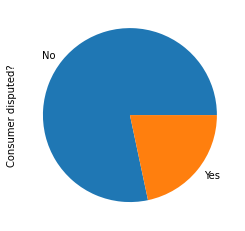

In [435]:
complaints['Consumer disputed?'].value_counts().plot(kind='pie')

In [436]:
complaints['Product'].value_counts()

Mortgage                   101680
Bank account or service     44594
Credit card                 42191
Debt collection              7861
Consumer Loan                5508
Student loan                 2866
Money transfers               869
Credit reporting              741
Prepaid card                  635
Other financial service       232
Payday loan                    83
Name: Product, dtype: int64

In [437]:
(complaints['Product'].value_counts() / (complaints['Product'].value_counts().sum()))*100

Mortgage                   49.059153
Bank account or service    21.515970
Credit card                20.356557
Debt collection             3.792821
Consumer Loan               2.657532
Student loan                1.382804
Money transfers             0.419280
Credit reporting            0.357522
Prepaid card                0.306378
Other financial service     0.111937
Payday loan                 0.040046
Name: Product, dtype: float64

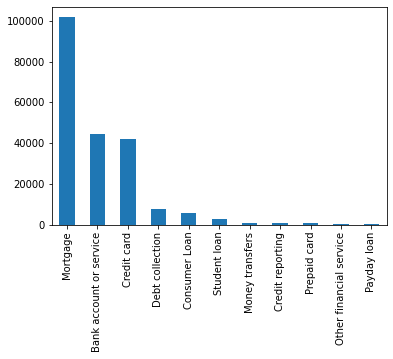

In [438]:
complaints['Product'].value_counts().plot(kind='bar')


In [439]:
complaints['Company'].value_counts()

BANK OF AMERICA, NATIONAL ASSOCIATION    65440
WELLS FARGO & COMPANY                    53111
JPMORGAN CHASE & CO.                     42170
CITIBANK, N.A.                           34341
U.S. BANCORP                             12198
Name: Company, dtype: int64

In [440]:
(complaints['Company'].value_counts() / (complaints['Company'].value_counts().sum()))*100

BANK OF AMERICA, NATIONAL ASSOCIATION    31.573869
WELLS FARGO & COMPANY                    25.625302
JPMORGAN CHASE & CO.                     20.346425
CITIBANK, N.A.                           16.569044
U.S. BANCORP                              5.885361
Name: Company, dtype: float64

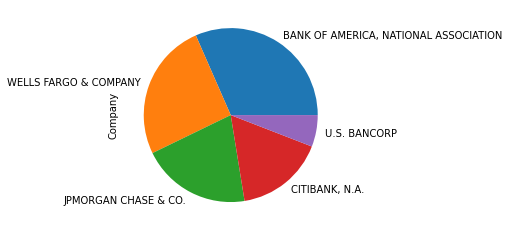

In [441]:
complaints['Company'].value_counts().plot(kind='pie')

In [442]:
complaints['Company response to consumer'].value_counts()

Closed with explanation            148930
Closed with monetary relief         22918
Closed with non-monetary relief     19005
Closed without relief               11119
Closed with relief                   2839
Closed                               2274
Untimely response                     175
Name: Company response to consumer, dtype: int64

In [443]:
(complaints['Company response to consumer'].value_counts() / (complaints['Company response to consumer'].value_counts().sum()))*100

Closed with explanation            71.856605
Closed with monetary relief        11.057609
Closed with non-monetary relief     9.169642
Closed without relief               5.364759
Closed with relief                  1.369777
Closed                              1.097173
Untimely response                   0.084435
Name: Company response to consumer, dtype: float64

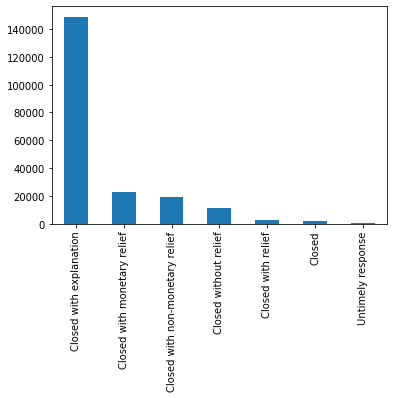

In [444]:
complaints['Company response to consumer'].value_counts().plot(kind='bar')

So we have an imbalanced dataset as only about 12% is in the `Yes` class.  This means we should consider rebalancing the training dataset using a technique such as SMOTE.  But we will do that after doing the train-test split.  But first, we need to think about what in our data should be the predictor variables, ie, what should be included as a feature in `X`.

## Deciding the feature set      
To do that, let us look at the dataset again.  And refer to the data-dictionary in the Word document for the project.  

|Field name  |Description  |Can it be a feature?  |
|------------  |------------  |------------  |
|Date received  |The date the CFPB received the complaint. For example, “05/25/2013.”  |Not a feature  |
|Product  |The type of product the consumer identified in the complaint. For example, “Checking or savings account” or “Student loan.”  |Yes  |
|Sub-product  |The type of sub-product the consumer identified in the complaint. For example, “Checking account” or “Private student loan.”  |Yes  |
|Issue  |The issue the consumer identified in the complaint. For example, “Managing an account” or “Struggling to repay your loan.”  |Yes  |
|Sub-issue  |The sub-issue the consumer identified in the complaint. For example, “Deposits and withdrawals” or “Problem lowering your monthly payments.”  |Yes  |
|Consumer complaint narrative  |Consumer complaint narrative is the consumer-submitted description of “what happened” from the complaint. Consumers must opt-in to share their narrative. We will not publish the narrative unless the consumer consents, and consumers can opt-out at any time. The CFPB takes reasonable steps to scrub personal information from each complaint that could be used to identify the consumer.  |Maybe, if we can convert text to some vector form  |
|Company public response  |The company’s optional, public-facing response to a consumer’s complaint. Companies can choose to select a response from a pre-set list of options that will be posted on the public database. For example, “Company believes complaint is the result of an isolated error.”  |Yes  |
|Company  |The complaint is about this company. For example, “ABC Bank.”  |Yes  |
|State  |The state of the mailing address provided by the consumer.  |Yes  |
|ZIP code  |The mailing ZIP code provided by the consumer. This field may: i) include the first five digits of a ZIP code; ii) include the first three digits of a ZIP code (if the consumer consented to publication of their complaint narrative); or iii) be blank (if ZIP codes have been submitted with non-numeric values, if there are less than 20,000 people in a given ZIP code, or if the complaint has an address outside of the United States).  |Yes  |
|Tags  |Data that supports easier searching and sorting of complaints submitted by or on behalf of consumers. For example, complaints where the submitter reports the age of the consumer as 62 years or older are tagged “Older American.” Complaints submitted by or on behalf of a servicemember or the spouse or dependent of a servicemember are tagged “Servicemember.” Servicemember includes anyone who is active duty, National Guard, or Reservist, as well as anyone who previously served and is a veteran or retiree.  |Yes  |
|Consumer consent provided?  |Identifies whether the consumer opted in to publish their complaint narrative. We do not publish the narrative unless the consumer consents, and consumers can opt-out at any time.  |Yes  |
|Submitted via  |How the complaint was submitted to the CFPB. For example, “Web” or “Phone.”  |Yes  |
|Date sent to company  |The date the CFPB sent the complaint to the company.  |Not relevant  |
|Company response to consumer  |This is how the company responded. For example, “Closed with explanation.”  |Yes  |
|Timely response?  |Whether the company gave a timely response. For example, “Yes” or “No.”  |Yes  |
|Consumer disputed?  |Whether the consumer disputed the company’s response.  |This the Target  |
|Complaint ID  |The unique identification number for a complaint.  |Not a feature  |


To begin with, let us ignore the text contained in 'Consumer complaint narrative' and look at the rest of the features.  We can come back to this later.

In [445]:
X = complaints[[ 'Product', 'Sub-product', 'Issue', 'Sub-issue',
        'Company public response', 'Company',
       'State',  'Tags',
       'Submitted via',  'Company response to consumer',
       'Timely response?']]

In [446]:
# Let us check if we have any missing values in our reduced dataset X

print(len(X)) # Number of rows before dropna()
print(len(X.dropna())) # Number of rows after dropna() 

207260
581


If we were to drop `NaN` values, we would be left with very few rows.  That means we need to think harder about `NaN` values.  

To do that, let us look at which columns are missing values.  

In [447]:
# Check how many values are missing in each column

X.isna().sum()

Product                              0
Sub-product                      43015
Issue                                0
Sub-issue                       196913
Company public response         148802
Company                              0
State                             2194
Tags                            178995
Submitted via                        0
Company response to consumer         0
Timely response?                     0
dtype: int64

**Now the question is: how do we deal with these missing values?  Let us look at what each of these columns contain.  We will do a `unique()` on these columns to see which are the values contained in these columns.**  

In [448]:
X['Sub-product'].unique()

array(['International money transfer', 'Other bank product/service',
       'Conventional fixed mortgage', 'Other mortgage',
       'Checking account', 'Vehicle lease', nan, 'Medical',
       'Conventional adjustable mortgage (ARM)', 'Vehicle loan',
       'Reverse mortgage', '(CD) Certificate of deposit', 'FHA mortgage',
       'Government benefit payment card', 'VA mortgage',
       'Savings account', 'Credit card',
       'Home equity loan or line of credit', 'Second mortgage',
       'Non-federal student loan', 'Installment loan',
       'Other special purpose card', 'Mortgage', 'I do not know',
       'Cashing a check without an account', 'Federal student loan',
       'Auto', 'Other (i.e. phone, health club, etc.)',
       'Personal line of credit', 'Domestic (US) money transfer',
       'General purpose card', 'Payday loan',
       'Traveler’s/Cashier’s checks', 'Refund anticipation check',
       'Federal student loan servicing', 'Debt settlement',
       'Gift or merchant card

X['Sub-issue'].unique()


In [449]:
X['State'].unique()

array([nan, 'PA', 'VA', 'GA', 'CA', 'MD', 'MN', 'WA', 'OK', 'TX', 'FL',
       'NJ', 'MA', 'WI', 'AZ', 'NY', 'DE', 'IL', 'CT', 'AE', 'MI', 'TN',
       'NH', 'MO', 'DC', 'OH', 'WV', 'NC', 'NM', 'AL', 'NV', 'UT', 'SC',
       'AK', 'KY', 'HI', 'OR', 'KS', 'CO', 'IN', 'ID', 'NE', 'VT', 'LA',
       'RI', 'WY', 'MS', 'ME', 'MT', 'IA', 'AR', 'PR', 'ND', 'SD', 'AS',
       'AP', 'GU', 'VI', 'MH', 'FM', 'AA', 'MP', 'PW'], dtype=object)

In [450]:
X['Company public response'].unique()

array(['Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company chooses not to provide a public response', nan,
       'Company believes it acted appropriately as authorized by contract or law',
       'Company believes complaint represents an opportunity for improvement to better serve consumers',
       'Company believes complaint caused principally by actions of third party outside the control or direction of the company',
       'Company believes complaint is the result of an isolated error',
       'Company believes complaint relates to a discontinued policy or procedure',
       'Company believes the complaint is the result of a misunderstanding'],
      dtype=object)

In [451]:
X['Tags'].unique()

array([nan, 'Older American', 'Servicemember',
       'Older American, Servicemember'], dtype=object)

## Dealing with missing data  
It is clear that all of these fields that have missing data are categorical, or string, and we cannot use any numerical imputation method to fill the missing values. 

What I would propose is to remove the NaNs by putting the text 'missing' in its place.  That would mean that all missing items would be treated as a category that we humans understand to be missing, but for the machine it is just another category called 'missing'.  

Of course, you are welcome to try other approaches.  

In [452]:
X = X.fillna('missing')
X.dropna().shape

(207260, 11)

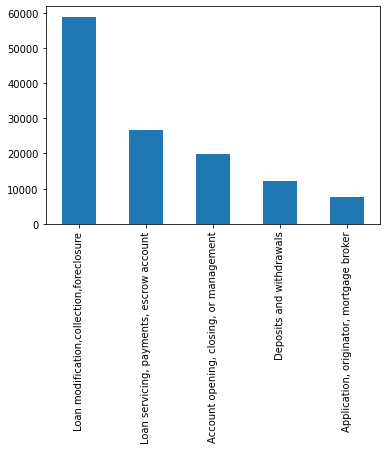

In [453]:
# X['Issue'].unique()
X['Issue'].value_counts()[:5].plot.bar()

In [454]:
(X['Issue'].value_counts() / (X['Issue'].value_counts()[:5].sum()))*100

Loan modification,collection,foreclosure    47.078933
Loan servicing, payments, escrow account    21.253415
Account opening, closing, or management     15.785102
Deposits and withdrawals                     9.804783
Application, originator, mortgage broker     6.077767
                                              ...    
Unable to get credit report/credit score     0.005591
Disclosures                                  0.004793
Can't stop charges to bank account           0.002396
Lender damaged or destroyed property         0.000799
Lender repossessed or sold the vehicle       0.000799
Name: Issue, Length: 93, dtype: float64

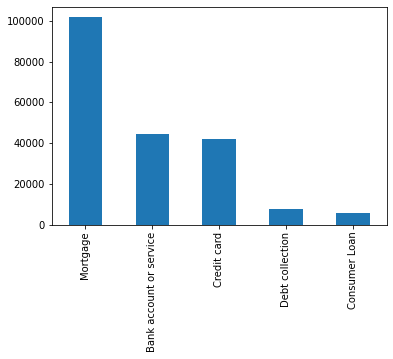

In [455]:

X['Product'].value_counts()[:5].plot.bar()

In [456]:
(X['Product'].value_counts() / (X['Product'].value_counts()[:5].sum()))*100

Mortgage                   50.378033
Bank account or service    22.094394
Credit card                20.903812
Debt collection             3.894785
Consumer Loan               2.728975
Student loan                1.419979
Money transfers             0.430552
Credit reporting            0.367133
Prepaid card                0.314615
Other financial service     0.114946
Payday loan                 0.041123
Name: Product, dtype: float64

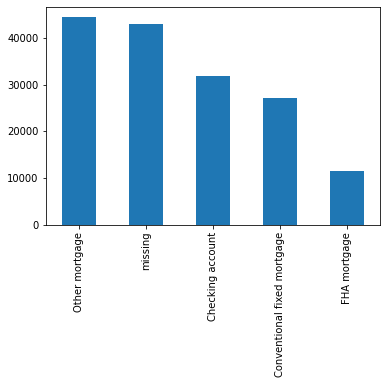

In [457]:

X['Sub-product'].value_counts()[:5].plot.bar()

In [458]:
(X['Sub-product'].value_counts() / (X['Sub-product'].value_counts()[:5].sum()))*100

Other mortgage                            28.113726
missing                                   27.225717
Checking account                          20.177981
Conventional fixed mortgage               17.155715
FHA mortgage                               7.326861
Conventional adjustable mortgage (ARM)     6.304037
Other bank product/service                 5.395775
Home equity loan or line of credit         3.703938
Credit card                                2.569085
Vehicle loan                               1.948808
Non-federal student loan                   1.852602
Savings account                            1.600061
VA mortgage                                1.210173
Installment loan                           0.862691
Other (i.e. phone, health club, etc.)      0.831677
(CD) Certificate of deposit                0.824715
Mortgage                                   0.756991
I do not know                              0.511412
Personal line of credit                    0.449384
Reverse mort

## Data prep
We see that there are no cells that have NAs any more after our operations above.  So it is safe to proceed.

In [459]:
# Next, we convert all the X observations into numbers

X = pd.get_dummies(X)


In [460]:
# Let us see what X looks like

print('X has the shape ',X.shape)

X

X has the shape  (207260, 306)


,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Money transfers,Product_Mortgage,Product_Other financial service,Product_Payday loan,Product_Prepaid card,...,Submitted via_Web,Company response to consumer_Closed,Company response to consumer_Closed with explanation,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Timely response?_No,Timely response?_Yes
0,0,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
207256,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
207257,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
207258,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1


**Let us get our _y_ variable**  

In [461]:
y = complaints['Consumer disputed?']

But y contains text, and we need to have 0s and 1s.  We can try to use LabelEncoder to do that

In [462]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(complaints['Consumer disputed?'])
print(le.classes_)
print(le.inverse_transform(list(set(y))))
labels = dict(zip(list(set(y)), le.inverse_transform(list(set(y)))))
print("\nLabel mapping is:", labels)


['No' 'Yes']
['No' 'Yes']

Label mapping is: {0: 'No', 1: 'Yes'}


## Train-test split  
We have our `X` and `y` defined.  Now let us do the train-test split

In [463]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Let us look at what our train and test sets look like.

In [464]:
# We check the shape of our X and y 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(165808, 306)
(165808,)
(41452, 306)
(41452,)


## Dealing with imbalanced data  
Since we have an imbalanced dataset, we should try to do something to oversample the minority category, or undersample the majority.  

We can do that using SMOTE.  To remind  yourself of what SMOTE is, refer to the slides from the Feature Engineering class.

If you want to try SMOTE, uncomment the lines in the cell below and run them - know that it will take a while!

### Oversampling with SMOTE

In [465]:
# from imblearn.over_sampling import SMOTE 
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)

**Looks like SMOTE is computationally very heavy, and does not produce great results for our models.**  

But because we have a lot of data, we can actually try undersampling too.  Interestingly, undersampling gives us better results in the modeling section later on.  

### Random Undersampling

In [466]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [467]:
# Let us check if the dataset is balanced
# just checking that the '1' category is exactly 50% of the training set

y_train.sum()/len(y_train) 

0.5

In [468]:
X_train.shape

(71768, 306)

In [469]:
pd.DataFrame(y_train).value_counts()

0    35884
1    35884
dtype: int64

In [470]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(207260, 306)
(71768, 306)
(41452, 306)


**Now everything is set up, we have X_train, y_train, X_test, y_test and a perfectly balanced dataset.  We can now feed it to a model of our choice, and look at the results.**  

## Fit a model using XGBoost

In [471]:
# Fit the model
from xgboost import XGBClassifier

model_xgb = XGBClassifier(use_label_encoder=False, objective= 'binary:logistic')
model_xgb.fit(X_train, y_train)

XGBClassifier(use_label_encoder=False)

In [472]:
# Perform predictions, and store the results in a variable called 'pred'
pred = model_xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.84      0.55      0.66     32433
           1       0.28      0.63      0.38      9019

    accuracy                           0.56     41452
   macro avg       0.56      0.59      0.52     41452
weighted avg       0.72      0.56      0.60     41452



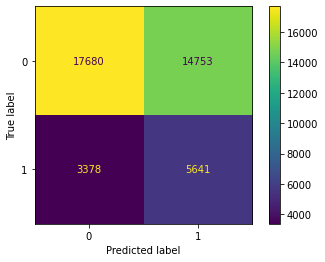

In [473]:
# Check the classification report and the confusion matrix

print(classification_report(y_true = y_test, y_pred = pred))

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## Calculating Total Cost in Dollars    
We know that the cost of a False Positive is \\$90, whereas the cost of a False Negative is \\$1500.  

Let us calculate the total cost based on our confusion matrix.  The confusion matrix has the false positives and the false negatives in the cells outside the main diagonal.  

In [474]:
False_Positive_Cost = 90 * cm[0,1]
False_Negative_Cost = 1500 * cm[1,0]

In [475]:
Total_cost = False_Positive_Cost + False_Negative_Cost
Total_cost

6394770

## What should we do now?  

We are able to obtain the probability for a complaint being a "1" (which means 'yes').  The default is generally 0.5, which means if the probability of something being a dispute is more than 0.5, we consider it as 'yes', and if the prob is <0.5, we consider it a 'no'.  But we can change this threshold because we are very interested in finding future disputes even if we end up with more false positives.  This means we can play with the 0.5 threshold.  

On average, it costs the banks \\$100 to resolve, respond to and close a complaint that is not disputed .  On the other hand, it costs banks an extra \\$1500 to resolve a complaint if it has been disputed.  

Our goal is to create and evaluate a predictive model that can help the banks identify future disputes so they can perform “extra diligence” during the first round of addressing the complaint with a view to avoiding eventual disputes.  If a complaint is picked up for “extra diligence”, it costs the bank an extra \\$90 to perform the additional diligence steps.  

It is clear that the cost of extra diligence is very low (\\$90), but if a complaint reaches the dispute stage, the cost can get quite high (\\$1500).  So we would like to reduce false negatives from our predictive model, even if it means we push up false positives.  That is because the cost of false positives is quite low compared to the cost of false negatives.  

This means we want high recall, and are okay with a lower precision.  


![image.png](attachment:b6391366-6399-44c1-b9b2-3ce2b72d0708.png)    
<img src = "attachment:b6391366-6399-44c1-b9b2-3ce2b72d0708.png" width = "500">  

We can look at our options using the ROC curve, but the ROC curve uses False Positive and True Positive rates (not precision and recall).  Roughly, we want a high True Positive rate (that minimizes FNs) and are okay if the False Positive rate goes up.  

Recall the formulae for TP and FP rates:  
![image.png](attachment:b24e2295-efa6-4b35-af8f-8732cc579e88.png)

**This means we can play around with the threshold that decides what is marked as 'yes'.  Feel free to reduce this threshold on the next cell, and see if it helps you get better recall for category 1 (that may reduce accuracy, but that is okay).**   
## Adjusting the threshold  
Let us lower the threshold to 0.4 and see what happens to our confusion matrix, and if we can lower our total cost.



Confusion Matrix : 
 [[ 5920 26513]
 [  671  8348]]
Test accuracy =  0.3442053459422947
              precision    recall  f1-score   support

           0       0.90      0.18      0.30     32433
           1       0.24      0.93      0.38      9019

    accuracy                           0.34     41452
   macro avg       0.57      0.55      0.34     41452
weighted avg       0.75      0.34      0.32     41452



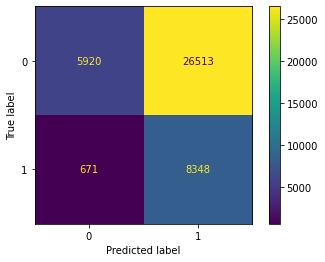

In [476]:
# Set threshold for identifying class 1
threshold = 0.4

# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))
print(classification_report(y_true = y_test, y_pred = pred))

So we see that recall has gone up to 90% from a lower number earlier.

In [477]:
# See what predicted probabilities look like
pred_prob

array([0.5697733 , 0.5935457 , 0.57532233, ..., 0.47321337, 0.50052756,
       0.43346137], dtype=float32)

In [478]:
pred

array([1, 1, 1, ..., 1, 1, 1])

In [479]:
# pred_prob = pred_prob[:,1]

**Calculating Total Cost in Dollars**  
We know that the cost of a False Positive is \\$90, whereas the cost of a False Negative is \\$1500.  

Let us calculate the total cost based on our confusion matrix.

In [480]:
False_Positive_Cost = 90 * cm[0,1]
False_Negative_Cost = 1500 * cm[1,0]

In [481]:
Total_cost = False_Positive_Cost + False_Negative_Cost
Total_cost

3392670

Now you can see how you can play around with the threshold and change your total cost.  In fact, you could create a loop to go through many possibiities of thresholds and find out the optimal threshold that leads to the minimum cost.  1m

## AUC and ROC calculation

In [482]:
# AUC calculation
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.6156394014961928

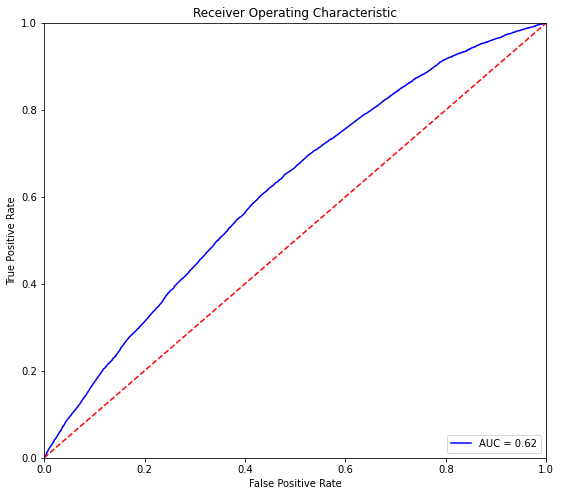

In [483]:
# Source for code below: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [484]:
pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds}).sort_values(by = ['Threshold']).reset_index(drop=True)

,TPR,FPR,Threshold
0,1.000000,1.000000,0.069911
1,1.000000,0.999938,0.071119
2,1.000000,0.999846,0.073245
3,1.000000,0.999692,0.081895
4,1.000000,0.999630,0.082188
...,...,...,...
6167,0.000111,0.000123,0.715607
6168,0.000111,0.000092,0.715713
6169,0.000000,0.000092,0.720691
6170,0.000000,0.000031,0.744125


## What else?

At this point, we can experiment with the threshold to determine the lowest cost.  We will find it is related to our precision and recall calculations.  Hopefully, we can make an actionable recommendation to the Big Banks Board, and they will hire us for the job!

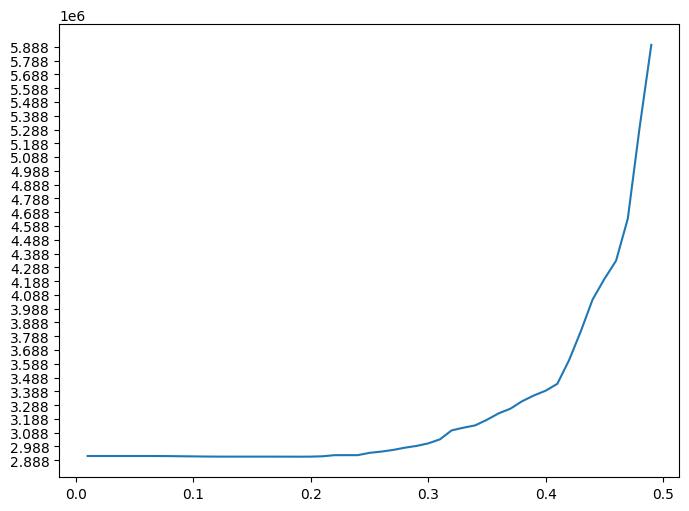

In [485]:
cost = []
thres = []
# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]


for threshold in range(1, 50, 1):
  # Set threshold for identifying class 1
  threshold/=100

  # Convert probabilities to 1s and 0s based on threshold
  pred = (pred_prob>threshold).astype(int)
  cm = confusion_matrix(y_test, pred)
  False_Positive_Cost = 90 * cm[0,1]
  False_Negative_Cost = 1500 * cm[1,0]
  Total_cost = False_Positive_Cost + False_Negative_Cost
  cost.append(Total_cost)
  thres.append(threshold)
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(thres, cost)
plt.yticks(np.arange(min(cost)-26000, max(cost),100000))
plt.show()

Confusion Matrix : 
 [[ 1967 30466]
 [  179  8840]]
Test accuracy =  0.26071118402007143
              precision    recall  f1-score   support

           0       0.92      0.06      0.11     32433
           1       0.22      0.98      0.37      9019

    accuracy                           0.26     41452
   macro avg       0.57      0.52      0.24     41452
weighted avg       0.77      0.26      0.17     41452



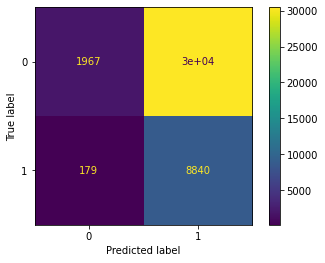

In [486]:
threshold = 0.3

pred_prob = model_xgb.predict_proba(X_test)

pred_prob = pred_prob[:,1]

pred = (pred_prob>threshold).astype(int)

cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

print('Test accuracy = ', accuracy_score(y_test, pred))
print(classification_report(y_true = y_test, y_pred = pred))

In [487]:
False_Positive_Cost = 90 * cm[0,1]
False_Negative_Cost = 1500 * cm[1,0]
Total_cost = False_Positive_Cost + False_Negative_Cost
Total_cost

3010440

In [488]:
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.6156394014961928

Confusion Matrix : 
 [[   67 32366]
 [    1  9018]]
Test accuracy =  0.21916915950979446
              precision    recall  f1-score   support

           0       0.99      0.00      0.00     32433
           1       0.22      1.00      0.36      9019

    accuracy                           0.22     41452
   macro avg       0.60      0.50      0.18     41452
weighted avg       0.82      0.22      0.08     41452



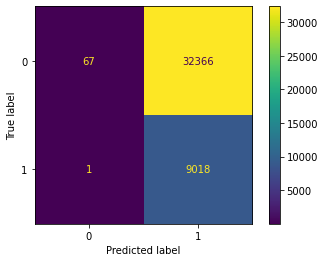

In [489]:
threshold = 0.2

pred_prob = model_xgb.predict_proba(X_test)

pred_prob = pred_prob[:,1]

pred = (pred_prob>threshold).astype(int)

cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

print('Test accuracy = ', accuracy_score(y_test, pred))
print(classification_report(y_true = y_test, y_pred = pred))

In [490]:
False_Positive_Cost = 90 * cm[0,1]
False_Negative_Cost = 1500 * cm[1,0]
Total_cost = False_Positive_Cost + False_Negative_Cost
Total_cost

2914440

In [491]:
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.6156394014961928

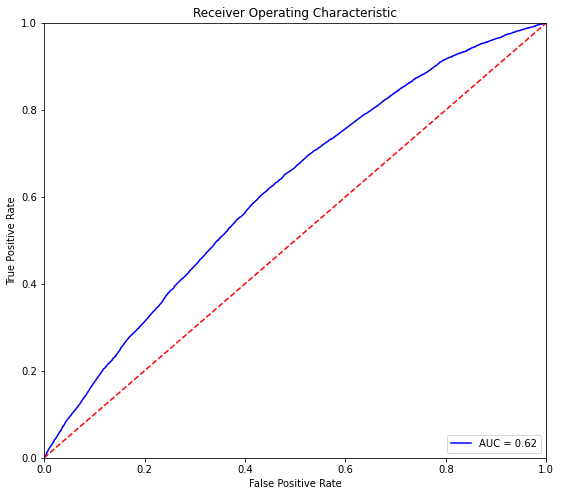

In [492]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix : 
 [[   31 32402]
 [    0  9019]]
Test accuracy =  0.21832480941812216
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     32433
           1       0.22      1.00      0.36      9019

    accuracy                           0.22     41452
   macro avg       0.61      0.50      0.18     41452
weighted avg       0.83      0.22      0.08     41452



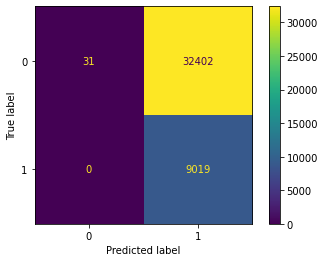

In [493]:
threshold = 0.1

pred_prob = model_xgb.predict_proba(X_test)

pred_prob = pred_prob[:,1]

pred = (pred_prob>threshold).astype(int)

cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

print('Test accuracy = ', accuracy_score(y_test, pred))
print(classification_report(y_true = y_test, y_pred = pred))

In [494]:
False_Positive_Cost = 90 * cm[0,1]
False_Negative_Cost = 1500 * cm[1,0]
Total_cost = False_Positive_Cost + False_Negative_Cost
Total_cost

2916180

In [495]:
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.6156394014961928

## Try a different model?

We only tried XGBoost, but we can try any other model that we learned.  We can also try to build a neural network for the prediction of customer disputes.  Maybe those give us better results.

Below we try logistic regression.

In [496]:
model = sm.Logit(y_train, X_train).fit(method='bfgs')
model.summary()

         Current function value: 0.673549
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                71768
Model:                          Logit   Df Residuals:                    71506
Method:                           MLE   Df Model:                          261
Date:                Sat, 30 Apr 2022   Pseudo R-squ.:                 0.02827
Time:                        21:27:35   Log-Likelihood:                -48339.
converged:                      False   LL-Null:                       -49746.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================================================================================================================================
                                                                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Product_Bank account or service                                                                                                                    -0.0250        nan        nan        nan         nan         nan
Product_Consumer Loan                                                                                                                               0.0073        nan        nan        nan         nan         nan
Product_Credit card                                                                                                                                 0.0851        nan        nan        nan         nan         nan
Product_Credit reporting                                                                                                                           -0.1020        nan        nan        nan         nan         nan
Product_Debt collection                                                                                                                            -0.1626        nan        nan        nan         nan         nan
Product_Money transfers                                                                                                                            -0.0006        nan        nan        nan         nan         nan
Product_Mortgage                                                                                                                                   -0.0238        nan        nan        nan         nan         nan
Product_Other financial service                                                                                                                     0.0330        nan        nan        nan         nan         nan
Product_Payday loan                                                                                                                                -0.0001        nan        nan        nan         nan         nan
Product_Prepaid card                                                                                                                               -0.0354        nan        nan        nan         nan         nan
Product_Student loan                                                                                                                               -0.0828        nan        nan        nan         nan         nan
Sub-product_(CD) Certificate of deposit                                                                                                             0.1918        nan        nan        nan         nan         nan
Sub-product_Auto                                             

### Predict test set and evaluate  

**You can play with the threshold to get the right True Positive rate you desire!  The default generally is 0.50 but you can change it to lower values - eg, 0.2**   

In [497]:

# Set threshold for identifying class 1
threshold = 0.20

In [498]:
# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model.predict(X_test)

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)
 
# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))

Confusion Matrix : 
 [[   73 32360]
 [    9  9010]]
Test accuracy =  0.21912091093312747


In [499]:
cm = confusion_matrix(y_test, pred)
pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,73,32360
Actual 1,9,9010


In [500]:
print(classification_report(y_true = y_test, y_pred = pred))

              precision    recall  f1-score   support

           0       0.89      0.00      0.00     32433
           1       0.22      1.00      0.36      9019

    accuracy                           0.22     41452
   macro avg       0.55      0.50      0.18     41452
weighted avg       0.74      0.22      0.08     41452



In [501]:
# See what predicted probabilities look like
pred_prob

51507     0.600726
185914    0.618422
129359    0.613995
93809     0.440947
199828    0.442956
            ...   
8339      0.471890
143690    0.392931
50896     0.463474
133915    0.486253
160031    0.411423
Length: 41452, dtype: float64

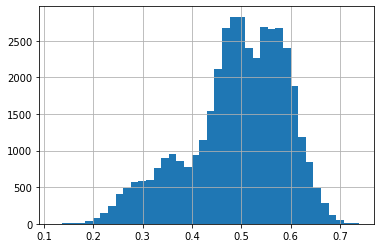

In [502]:
# A histogram of probabilities.  Why not?
pred_prob.hist(bins=40)

### AUC and ROC calculation

In [503]:
# AUC calculation
metrics.roc_auc_score(y_test, pred_prob)

0.606587287760495

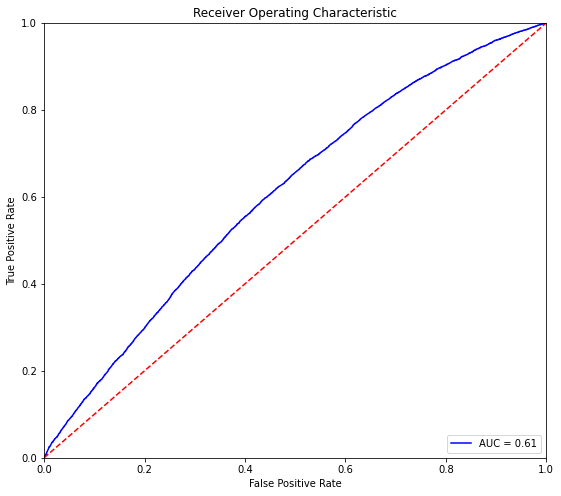

In [504]:
# Source for code below: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()